The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


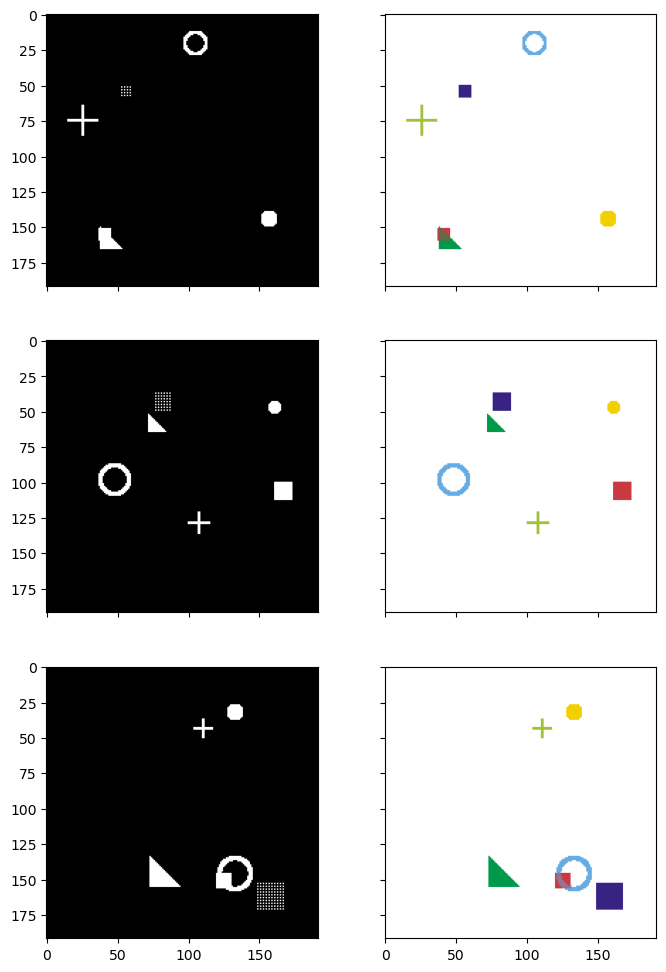

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [26]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import simulation

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform=trans)
val_set = SimDataset(200, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
-2.117904 2.64 -1.8739793 0.7078568
0.0 1.0 0.0051533566 0.07160151


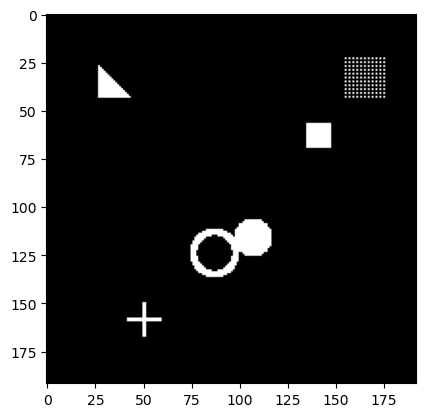

In [27]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [28]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
list(base_model.children())

/Users/lucawolfart/mambaforge/envs/dlscb/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [29]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

summary(base_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [36]:
import torch
import torch.nn as nn
#from ...neuralodes.utils import get_activation
from neuralodes.models.model_blocks import ConvolutionalODELayer
from neuralodes.models import ContinousNormalizingFlow

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class,
                ode_solver,
                activation="relu",
                with_norm="False",
                t0=0.0,
                t1=1.0,
                dt=0.1,):
        super().__init__()


        def ConvolutionalOdeLayerAndMaxPool(in_channels, out_channels, kernel_size=3):
            print("A", flush=True)
            ode_conv = ConvolutionalODELayer(
                ode_solver=ode_solver,
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                activation=activation,
                with_norm=with_norm,
                t0=t0,
                t1=t1,
                dt=dt,
            )
            print("B", flush=True)

            return nn.Sequential(ode_conv, nn.MaxPool2d(2))
        
        self.t0 = torch.tensor(t0, dtype=torch.float32)
        self.t1 = torch.tensor(t1, dtype=torch.float32)
        self.dt = torch.tensor(dt, dtype=torch.float32)
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())         
        # print("base layers length", len(self.base_layers))       
        # print("resnet18 base model", self.base_layers)
        for i in range(len(self.base_layers)):
            print("base layer", i, self.base_layers[i])
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)   
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        #self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2 = ConvolutionalOdeLayerAndMaxPool(64, 128)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        #self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)      
        self.layer3 = ConvolutionalOdeLayerAndMaxPool(128, 256)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        #self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4 = ConvolutionalOdeLayerAndMaxPool(256, 512)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        print("input shape", input.shape, flush=True)
        layer0 = self.layer0(input)     
        print("layer0 shape", layer0.shape, flush=True)       
        layer1 = self.layer1(layer0)
        print("layer1 shape", layer1.shape, flush=True)
        layer2 = self.layer2(layer1)
        print("layer2 shape", layer2.shape, flush=True)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [37]:
# check keras-like model summary using torchsummary

from torchsummary import summary
from neuralodes.ode_solver import get_ode_integrator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(6, 
                   ode_solver=get_ode_integrator(
                        method_low="explicit_euler",
                        method_high=None,
                        atol=1e-3,
                        rtol=1e-3,
                        return_all_states=False,
                    ),
                    with_norm="False",
                   ).to(device)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

Using a non-adaptive method.
base layer 0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
base layer 1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
base layer 2 ReLU(inplace=True)
base layer 3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
base layer 4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace

RuntimeError: The expanded size of the tensor (64) must match the existing size (128) at non-singleton dimension 1.  Target sizes: [2, 64, 56, 56].  Tensor sizes: [2, 128, 56, 56]

In [34]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)   
    return model

In [35]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from neuralodes.ode_solver import get_ode_integrator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = ResNetUNet(num_class, 
                   ode_solver=get_ode_integrator(
                        method_low="explicit_euler",
                        method_high=None,
                        atol=1e-3,
                        rtol=1e-3,
                        return_all_states=False,
                    ),
                   ).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

cpu
Using a non-adaptive method.
A
B
A
B
A
B
Epoch 0/14
----------
LR 0.0001


/Users/lucawolfart/mambaforge/envs/dlscb/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


input shape torch.Size([25, 3, 192, 192])
layer0 shape torch.Size([25, 64, 96, 96])
layer1 shape torch.Size([25, 64, 48, 48])


RuntimeError: The expanded size of the tensor (64) must match the existing size (128) at non-singleton dimension 1.  Target sizes: [25, 64, 48, 48].  Tensor sizes: [25, 128, 48, 48]

In [19]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

input shape torch.Size([3, 3, 192, 192])
layer0 shape torch.Size([3, 64, 96, 96])
layer1 shape torch.Size([3, 64, 48, 48])


RuntimeError: The expanded size of the tensor (64) must match the existing size (128) at non-singleton dimension 1.  Target sizes: [3, 64, 48, 48].  Tensor sizes: [3, 128, 48, 48]